In [2]:
import numpy as np 
import pandas as pd
import os
import random
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Conv2D,Flatten
from keras.layers import MaxPool2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import warnings

warnings.filterwarnings('ignore')


2022-12-09 01:59:50.417943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Importing csv
dirname = os.getcwd()
data = pd.read_csv(os.path.join(dirname, 'data/cards.csv'))
data = data[data.filepaths.str.endswith('.jpg')]
data

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
...,...,...,...,...,...
8024,51,valid/two of spades/1.jpg,two of spades,two,valid
8025,51,valid/two of spades/2.jpg,two of spades,two,valid
8026,51,valid/two of spades/3.jpg,two of spades,two,valid
8027,51,valid/two of spades/4.jpg,two of spades,two,valid


Found 7495 files belonging to 52 classes.
Found 257 files belonging to 52 classes.
Found 260 files belonging to 52 classes.
['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spad

2022-12-09 02:00:10.350705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


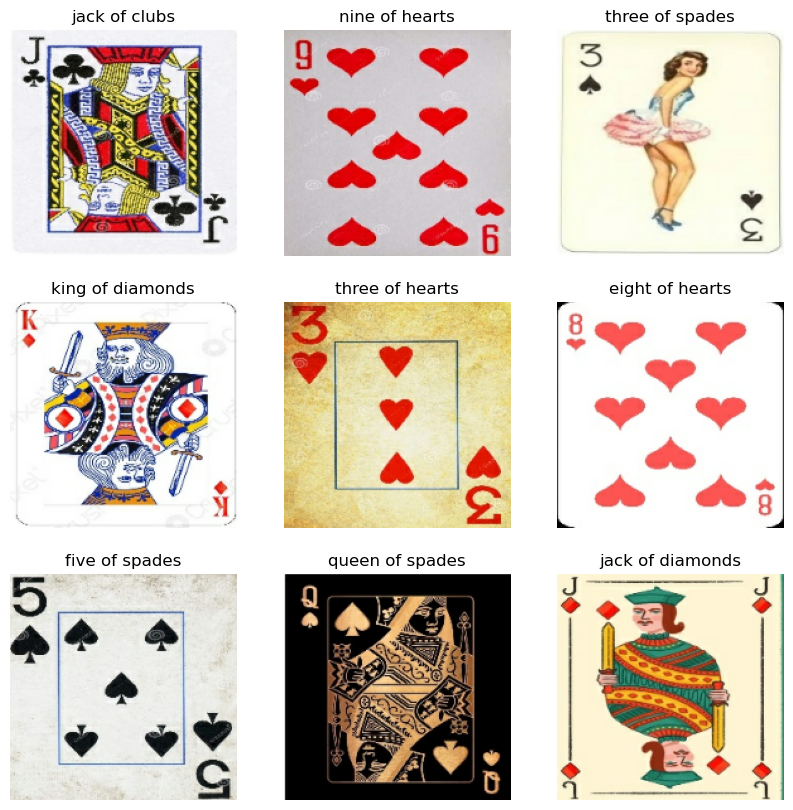

(32, 180, 180, 3)
(32,)


In [5]:
# Importing datasets
Train_ds=tf.keras.utils.image_dataset_from_directory(os.path.join(dirname,"data/train"),batch_size=32,image_size=(180,180),seed=56)
Test_ds=tf.keras.utils.image_dataset_from_directory(os.path.join(dirname,"data/test"),batch_size=32,image_size=(180,180),seed=56)
Valid_ds=tf.keras.utils.image_dataset_from_directory(os.path.join(dirname,"data/valid"),batch_size=32,image_size=(180,180),seed=56)
Class_Names=Train_ds.class_names
print(Class_Names)

plt.figure(figsize=(10,10))
for images, labels in Test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(Class_Names[labels[i]])
        plt.axis("off")
plt.show()

for image_batch, labels_batch in Train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [6]:
# Fast processing
AUTOTUNE = tf.data.AUTOTUNE
Train_ds = Train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
Valid_ds = Valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes=len(Class_Names)

In [7]:
# Building the model
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

# Compiling
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [8]:
# Fitting the model
history = model.fit(Train_ds,validation_data=Valid_ds,epochs=16)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(acc,val_acc,loss,val_loss)

Epoch 1/16
235/235 [==============================] - 70s 289ms/step - loss: 3.3475 - accuracy: 0.1314 - val_loss: 2.0401 - val_accuracy: 0.3346
Epoch 2/16
235/235 [==============================] - 70s 297ms/step - loss: 2.0881 - accuracy: 0.3797 - val_loss: 1.3676 - val_accuracy: 0.5500
Epoch 3/16
235/235 [==============================] - 70s 298ms/step - loss: 1.4986 - accuracy: 0.5844 - val_loss: 0.9281 - val_accuracy: 0.7346
Epoch 4/16
235/235 [==============================] - 72s 306ms/step - loss: 1.1177 - accuracy: 0.6861 - val_loss: 0.6727 - val_accuracy: 0.8038
Epoch 5/16
235/235 [==============================] - 69s 292ms/step - loss: 0.8232 - accuracy: 0.7581 - val_loss: 0.6324 - val_accuracy: 0.8269
Epoch 6/16
235/235 [==============================] - 66s 279ms/step - loss: 0.6374 - accuracy: 0.8099 - val_loss: 0.4965 - val_accuracy: 0.8462
Epoch 7/16
235/235 [==============================] - 68s 287ms/step - loss: 0.4620 - accuracy: 0.8594 - val_loss: 0.4658 - val_ac

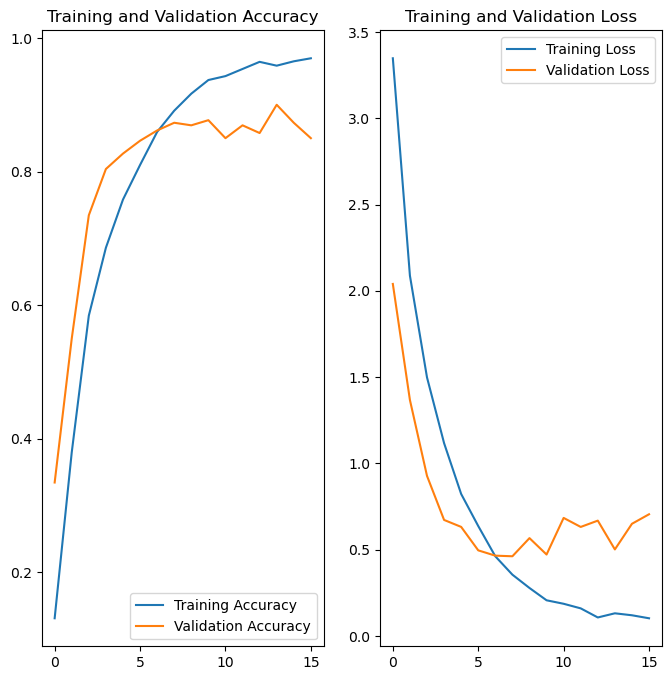

In [10]:
epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
#Saving the model
model.save(os.path.join(dirname,"model/"))

INFO:tensorflow:Assets written to: /Users/hborkar/Desktop/550/blackjack/model/assets


INFO:tensorflow:Assets written to: /Users/hborkar/Desktop/550/blackjack/model/assets


In [6]:
# Loading the model
dirname = os.getcwd()
model = keras.models.load_model(os.path.join(dirname,"model/"))

1/1 [==============================] - 0s 30ms/step


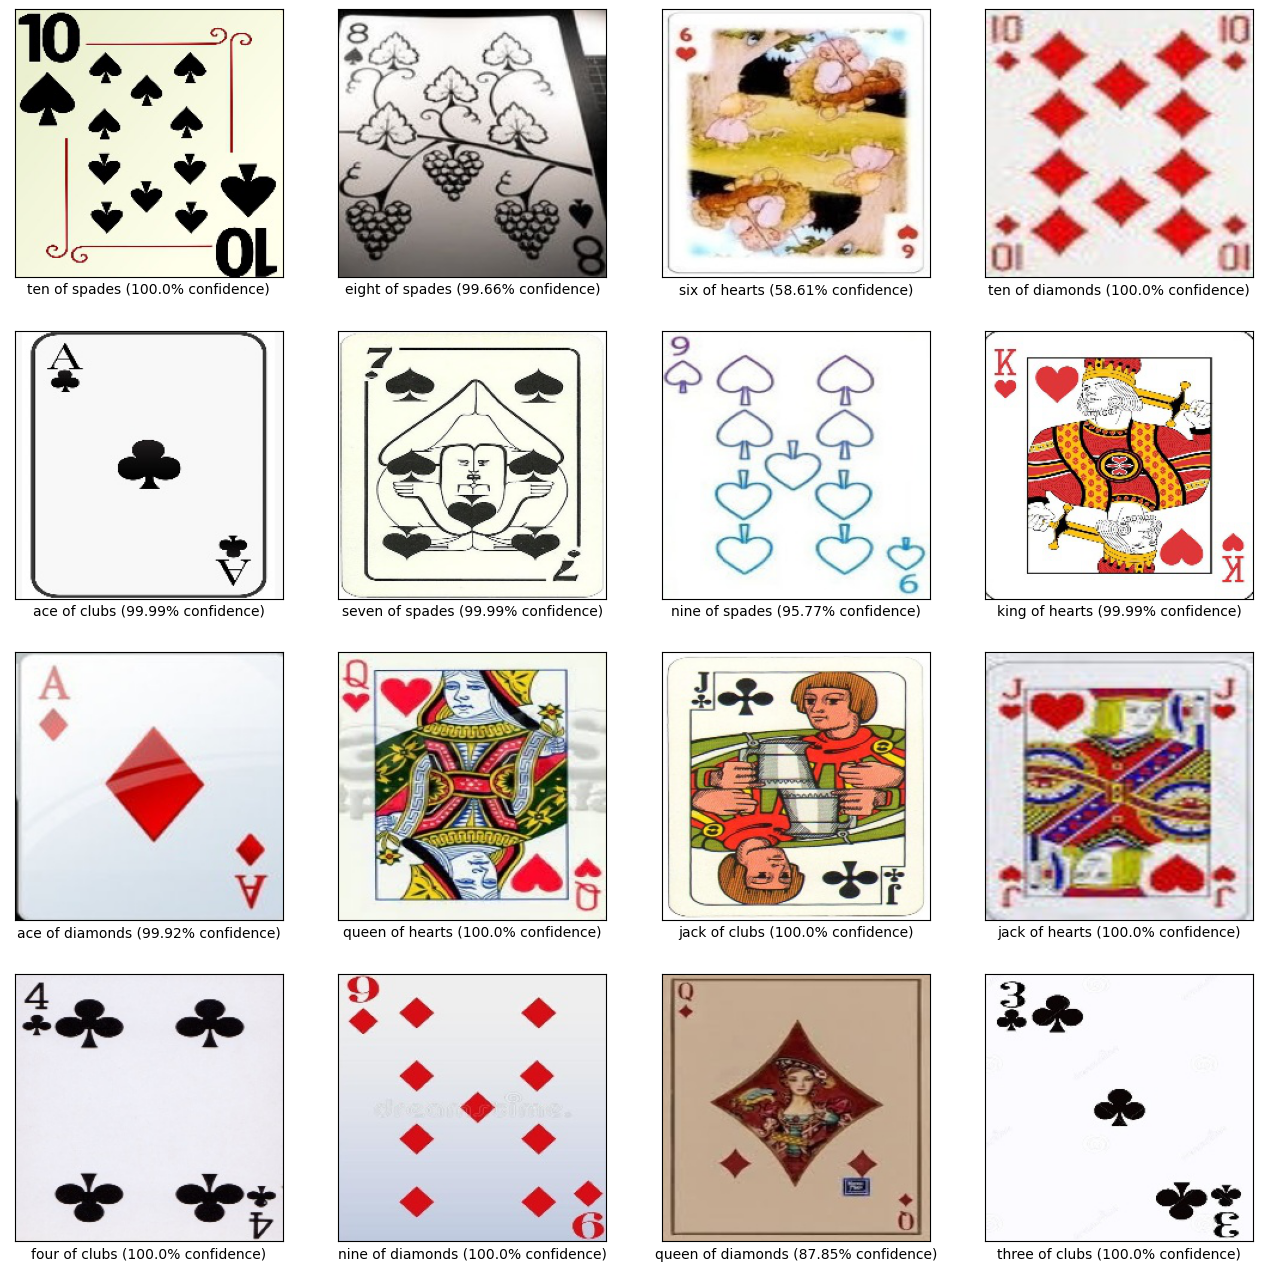

In [11]:
# Testing against random images
file_list = data['filepaths'].tolist()

plt.figure(figsize=(16,16))
for i in range(16):
    file = file_list[random.randint(0, len(file_list))]
    path = os.path.join(dirname, "data/"+file)
    img = tf.keras.utils.load_img(path, target_size=(180,180))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions=model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mpimg.imread(path))
    plt.xlabel(str(Class_Names[np.argmax(score)]) +" ("+str(round(100 * np.max(score),2))+"% confidence)")

plt.show()